# Model deployment
We're going to make the model available for use. The metrics of focus are:
1.  Performs well (~95% accuracy)
2.  Fast inference timings (30ms latency)

## 1. Seting up for model experiments
* We are going to develop and choose from either the EffNetB2 and ViT feature extractor models for deployment.
* Thereafter we're going to finetune the chosen model on the entire FoodVision dataset

In [21]:
import os
from pathlib import Path

import sys
sys.path.append("../")
from src.utils import get_device, plot_loss_curves
from going_modular import data_setup, engine
from going_modular.get_data import get_data
from going_modular.utils import save_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

from tqdm.notebook import tqdm

print("PyTorch version: ",torch.__version__)
print("Torchvision version: ",torchvision.__version__)

PyTorch version:  2.0.1
Torchvision version:  0.15.2


Set hyperparameters

In [2]:
BATCH_SIZE = 32 # The paper uses 4096 which is too big for a normal computer's hardware
NUM_WORKERS = 0 # MPS cannot work with more than 0
EPOCHS = 10
LR = 0.001
SEED = 42
IMG_SIZE = 224 #dimensions used by the ViT paper

Set device

In [3]:
device = get_device()
device

'mps'

Set data pathways

In [13]:
# Download pizza, steak, sushi images from GitHub
data = get_data(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                image_dir = "pizza_steak_sushi_20_percent")

data

Creating data/pizza_steak_sushi_20_percent directory...
Unziping pizza_steak_sushi data...


{'status': 'Data extracted successfully'}

In [15]:
data_path = Path("data/pizza_steak_sushi_20_percent")
train_dir = data_path / "train"
test_dir = data_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. EfficientNetB2 feature extractor

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

summary(effnetb2)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /Users/tituslim/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 50.0MB/s]


Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    │    └─MBConv: 3-5                                 612
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-6                                 6,004
│    │    └─MBConv: 3-7                                 10,710
│    │    └─MBConv: 3-8                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-9                                 16,518
│    │    └─MBConv: 3-10       

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
for parameter in effnetb2.parameters():
    parameter.requires_grad = False

torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features = 1408, out_features = 3, bias = True)
)

summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [16]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb2_transforms,
    batch_size = BATCH_SIZE
)

In [17]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2)

(15, 5)

Training the effnetb2 model

In [19]:
opt_effnetb2 = torch.optim.Adam(params = effnetb2.parameters(),
                                lr  = LR)
loss_fn = nn.CrossEntropyLoss()

torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

effnetb2_results = engine.train(
    model = effnetb2.to(device),
    train_dataloader = train_dataloader_effnetb2,
    test_dataloader = test_dataloader_effnetb2,
    epochs = EPOCHS,
    optimizer = opt_effnetb2,
    loss_fn = loss_fn,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9817 | train_acc: 0.5729 | test_loss: 0.7343 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.7070 | train_acc: 0.8667 | test_loss: 0.5739 | test_acc: 0.9500
Epoch: 3 | train_loss: 0.6039 | train_acc: 0.8167 | test_loss: 0.4819 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.4490 | train_acc: 0.9021 | test_loss: 0.4318 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.4287 | train_acc: 0.9104 | test_loss: 0.3894 | test_acc: 0.9472
Epoch: 6 | train_loss: 0.4202 | train_acc: 0.8833 | test_loss: 0.3528 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4224 | train_acc: 0.8396 | test_loss: 0.3256 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3951 | train_acc: 0.8875 | test_loss: 0.3461 | test_acc: 0.9472
Epoch: 9 | train_loss: 0.3832 | train_acc: 0.8771 | test_loss: 0.3104 | test_acc: 0.9347
Epoch: 10 | train_loss: 0.3655 | train_acc: 0.8604 | test_loss: 0.2837 | test_acc: 0.9625


Very good test accuracy scores!

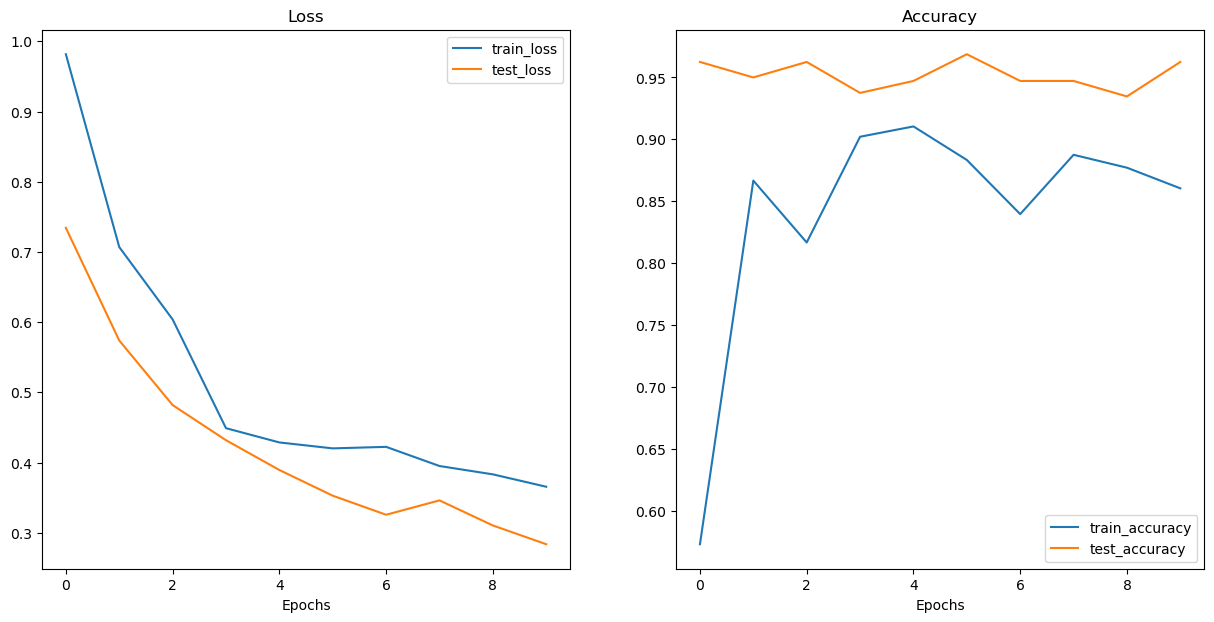

In [20]:
plot_loss_curves(effnetb2_results)

In [22]:
save_model(model = effnetb2,
           root_dir = "models",
           model_name = "finetuned_effnetb2_20percent.pth") 

Saved model to: models/finetuned_effnetb2_20percent.pth


In [26]:
effnet_size = Path("models/finetuned_effnetb2_20percent.pth").stat().st_size / (1024*1024)
print(f"EffNetB2 feature extractor model size: {effnet_size:.2f} MB")

EffNetB2 feature extractor model size: 29.83 MB


In [33]:
# Collect effnetb2 model statistics
effnetb2_total_params = sum(
    torch.numel(param) for param in effnetb2.parameters()
)
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                  'test_accuracy': effnetb2_results['test_acc'][-1],
                  'model_size (MB)': effnet_size,
                  'total_params': effnetb2_total_params}
effnetb2_stats

{'test_loss': 0.2836607605218887,
 'test_accuracy': 0.9625,
 'model_size (MB)': 29.82852077484131,
 'total_params': 7705221}

## 3. ViT Feature Extractor

In [35]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

vit = torchvision.models.vit_b_16(
    weights = vit_weights
)

vit_transforms = vit_weights.transforms()

# Freeze base parameters
for parameter in vit.parameters():
    parameter.requires_grad = False

# Replace MLP head
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

# Set top layer as trainable
vit.heads = nn.Linear(in_features = 768,
                      out_features = 3 #we only have 3 classes
                      )

summary(vit, 
        input_size = (1, 3, 224, 224), #(batch_size, color_channels, img_size, img_size)
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [37]:
#Setup dataloaders
train_dataloader_vit, test_dataloader_vit, _ = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = vit_transforms,
    batch_size = BATCH_SIZE #we can setup a higher batch size because there are less weight updates
)

In [38]:
opt_vit = torch.optim.Adam(params = vit.parameters(),
                           lr  = LR)

torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

vit_results = engine.train(
    model = vit.to(device),
    train_dataloader = train_dataloader_vit,
    test_dataloader = test_dataloader_vit,
    epochs = EPOCHS,
    optimizer = opt_vit,
    loss_fn = loss_fn,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


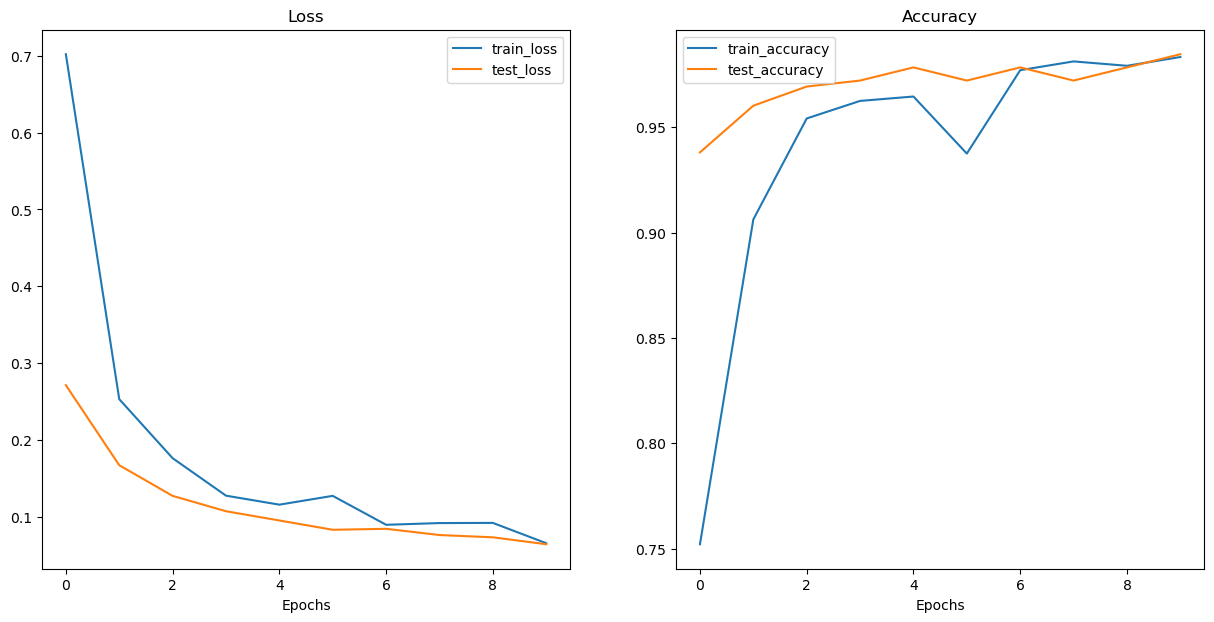

In [39]:
plot_loss_curves(vit_results)

In [40]:
save_model(model = vit,
           root_dir = "models",
           model_name = "finetuned_vit_20percent.pth") 
vit_size = Path("models/finetuned_vit_20percent.pth").stat().st_size / (1024*1024)
print(f"ViT feature extractor model size: {vit_size:.2f} MB\n")

# Collect effnetb2 model statistics
vit_total_params = sum(
    torch.numel(param) for param in vit.parameters()
)
vit_stats = {'test_loss': vit_results['test_loss'][-1],
                  'test_accuracy': vit_results['test_acc'][-1],
                  'model_size (MB)': vit_size,
                  'total_params': vit_total_params}
vit_stats

Saved model to: models/finetuned_vit_20percent.pth
ViT feature extractor model size: 327.36 MB



{'test_loss': 0.06443448234349489,
 'test_accuracy': 0.984659090909091,
 'model_size (MB)': 327.362229347229,
 'total_params': 85800963}

The ViT model has better accuracy but is clearly slower to finetune and requires more storage space.

## 4. Timing model inference timings

In [45]:
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')]

In [76]:
from typing import List, Dict
from timeit import default_timer as timer

def pred_and_store(
    paths: List[Path],
    model: nn.Module,
    transform: transforms,
    class_name: List[str],
    device: str = device) -> List[Dict]:
    """Runs the pytorch model against the test set and compiles model
    statistics for decision-making. A dictionary containing model inference
    statistics is created for each sample and appended to a list to be
    returned.

    Args:
        paths (List[Path]): List of pathlib path objects of test images
        model (nn.Module): Torch model
        transform (transforms): Torch transforms
        class_name (List[str]): List of class names
        device (str, optional): Torch device. Defaults to device.

    Returns:
        List[Dict]: List of dictionaries.
    """
    pred_list = []
    for path in tqdm(paths):
        pred_dict = dict()
        pred_dict['image_path'] = path
        pred_dict['class_name'] = path.parent.stem
        
        start_time = timer()
        
        # Read image
        img = Image.open(path)
        transformed_img = transform(img).unsqueeze(0).to(device) #Add batch dim
        
        # Run inference
        model = model.to(device)
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_img)
            pred_prob = torch.softmax(pred_logit, dim  = 1)
            pred_label = torch.argmax(pred_prob, dim = 1)
            pred_class = class_name[pred_label.cpu()]
        
        pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4
                                       )
        pred_dict['pred_class'] = pred_class
        
        end_time = timer()
        
        # Update pred_dict
        pred_dict['time_for_pred'] = round(end_time - start_time, 4)
        pred_dict['correct'] = pred_dict['class_name'] == pred_class
        
        #Update pred_list
        pred_list.append(pred_dict)
    
    return pred_list

In [77]:
effnetb2_pred_list = pred_and_store(
    paths = test_data_paths,
    model = effnetb2,
    transform = effnetb2_transforms,
    class_name = class_names,
    device = device
)

  0%|          | 0/150 [00:00<?, ?it/s]

In [78]:
effnetb2_df = pd.DataFrame(effnetb2_pred_list)
effnetb2_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9153,steak,0.8634,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9216,steak,0.0417,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8720,steak,0.0354,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6192,steak,0.0360,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.5794,steak,0.0377,True


In [79]:
effnetb2_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [80]:
print(
    f"""
    EffNetB2 average inference time:
    {round(effnetb2_df.time_for_pred.mean(), 4):.3f} seconds
    """
)


    EffNetB2 average inference time:
    0.043 seconds
    


In [81]:
vit_pred_list = pred_and_store(
    paths = test_data_paths,
    model = vit,
    transform = vit_transforms,
    class_name = class_names,
    device = device
)

  0%|          | 0/150 [00:00<?, ?it/s]

In [82]:
vit_df = pd.DataFrame(vit_pred_list)
vit_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7962,steak,0.0464,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9981,steak,0.0346,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9959,steak,0.0324,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9863,steak,0.0339,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9519,steak,0.0328,True


In [83]:
vit_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [84]:
print(
    f"""
    ViT average inference time:
    {round(vit_df.time_for_pred.mean(), 4):.3f} seconds
    """
)


    ViT average inference time:
    0.033 seconds
    


In [91]:
df = pd.DataFrame([effnetb2_stats,
                   vit_stats])
df['avg_inference_time'] = [round(effnetb2_df.time_for_pred.mean(), 4),
                            round(vit_df.time_for_pred.mean(), 4)]
df['test_accuracy'] = round(df['test_accuracy']*100, 2)
df['model'] = ['EffNetB2', 'ViT']
df

,test_loss,test_accuracy,model_size (MB),total_params,avg_inference_time,model
0,0.283661,96.25,29.828521,7705221,0.0435,EffNetB2
1,0.064434,98.47,327.362229,85800963,0.0326,ViT


Hey! The ViT model is slightly faster than the EfficientNetB2, and with better accuracy! Let's evaluate
* `test_loss` (lower is better) > ViT
* `test_accuracy` (higher is better) > ViT
* `total_params` (lower is better in general) > EffNetB2
* `model_size` (lower is better) > EffNetB2
* Inference timings (lower is better) > ViT

> ViT scoring faster inference timings is quite unexpected. But I guess it really depends on the hardware

We will deploy the EfficientNet because the model's storage requirements are smaller

## 5. Bringing FoodVision Mini to life in an app
Gradio is a popular machine learning demo library and directly integrates with HuggingFace Spaces.

In [93]:
#put the model on cpu for inference mode
vit = vit.to('cpu') 
next(iter(vit.parameters())).device

device(type='cpu')

In [107]:
from typing import Tuple, Dict
import PIL

# Write function to run inference on gradio
def predict(img: PIL.Image, 
            model: nn.Module = effnetb2,
            class_names: List[str] = class_names) -> Tuple[Dict, float]:
    """Function to predict image class on gradio

    Args:
        img (np.array): Image as a numpy array
        model (nn.Module, optional): Model. Defaults to vit.
        class_names (List[str], optional): List of class anmes. Defaults to class_names.

    Returns:
        Tuple[Dict, float]: Tuplefor further processing on gradio
    """
    start_time = timer()
    img = vit_transforms(img).unsqueeze(0) #add batch dimension
    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(vit(img), dim = 1)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    return pred_labels_and_probs, pred_time

#### Test predict function

In [100]:
import random
from PIL import Image

random_img_path = random.sample(test_data_paths, k=1)[0]
image = Image.open(random_img_path)
print(f"[INFO] Predicting on image: {random_img_path}\n")

pred_dict, pred_time = predict(img = image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image: data/pizza_steak_sushi_20_percent/test/steak/2756200.jpg

{'pizza': 0.005287931766360998, 'steak': 0.9194149971008301, 'sushi': 0.07529711723327637}
0.0889


#### Create example images for use in Gradio
> The examples for Gradio can be created with the `examples` parameter. 

In [109]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg']]

#### Building the Gradio interface

In [113]:
import gradio as gr

# Create title, description and article
title = 'FoodVision Mini 🍕🥩🍣'
description = "Using a [Vision Transformer](https://arxiv.org/abs/2010.11929) for Image Classification"
article = "Created by [Titus Lim](https://github.com/tituslhy)"

demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type = "pil"),
                    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
                               gr.Number(label = "Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)

demo.launch(debug = False, #prints errors locally
            share = True # Generate a publicly shareable URL
            )

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


In [112]:
gr.close_all()

Closing server running on port: 7861
Closing server running on port: 7860
Closing server running on port: 7863
Closing server running on port: 7862


## Deploying FoodVision Mini to HuggingFace Spaces
We will be creating the app structure as below. Do note that we need to use GitHub LFS (Large File System) to upload the pth model to HuggingFace Spaces. 

```
demos/
└── foodvision_mini/
    ├── finetuned_effnetb2_20percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

> Alternatively you could also deploy via FastAPI and create the app.py to call the API for an inference. You'll need a server to run the FastAPI though.

In [108]:
import shutil

# Create the demos directory
foodvision_mini_demo_path = Path("demos/foodvision_mini/")
if os.path.exists(foodvision_mini_demo_path):
    shutil.rmtree(foodvision_mini_demo_path)
foodvision_mini_demo_path.mkdir(parents = True, exist_ok=True)

!ls demos/foodvision_mini/

In [114]:
# Create examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents = True, exist_ok = True)
!ls demos/foodvision_mini/examples

In [119]:
foodvision_mini_examples = [Path(example_list[i][0]) for i in range(len(example_list))]
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src = example, dst = destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg to demos/foodvision_mini/examples/3375083.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg to demos/foodvision_mini/examples/1683426.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg to demos/foodvision_mini/examples/2246332.jpg


In [121]:
# Get example filepaths as a list of lists
app_examples = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
app_examples

[['examples/2246332.jpg'], ['examples/1683426.jpg'], ['examples/3375083.jpg']]

In [125]:
# Move model into app
model_path = "Models/finetuned_effnetb2_20percent.pth"
model_dest = foodvision_mini_demo_path / model_path.split("/")[1]
try:
    print(f"[INFO] Moving {model_path} to {model_dest}")
    shutil.move(model_path, model_dest)
    print(f"[INFO] Model move complete")
except Exception as e:
    print(f"[INFO] No model found at {model_path}")
    if model_dest.exists():
        print(f"[INFO] Model already exists at {model_dest}")
    else:
        print(str(e))

[INFO] Moving Models/finetuned_effnetb2_20percent.pth to demos/foodvision_mini/finetuned_effnetb2_20percent.pth
[INFO] Model move complete


Creating model.py

In [126]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    effnetb2_transforms = effnetb2_weights.transforms()
    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
    for param in effnetb2.parameters():
        param.requires_grad = False
    torch.manual_seed(seed)
    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p = 0.3, inplace = True),
        nn.Linear(in_features = 1408, out_features = num_classes)
    )
    return effnetb2, effnetb2_transforms

Writing demos/foodvision_mini/model.py


Creating app.py

In [131]:
type(effnetb2_transforms)

torchvision.transforms._presets.ImageClassification

In [132]:
%%writefile demos/foodvision_mini/app.py
"""The main parts are:
1. Imports and class names setup
2. Model and transforms preparation
3. Write a predict function for gradio to use
4. Write the Gradio app and the launch command
"""
import os
from typing import Tuple, Dict
import PIL
import torch
import torchvision
import gradio as gr
from timeit import default_timer
from model import create_effnetb2_model

class_names = ['pizza', 'steak', 'sushi'] #hardcoded as a list
model, transforms = create_effnetb2_model(num_classes = len(class_names))

# Load saved weights into the model, and load the model onto the CPU
model.load_state_dict(torch.load(f = "finetuned_effnetb2_20percent.pth"),
                      map_location = torch.device('cpu'))

# Write function to run inference on gradio
def predict(img: PIL.Image, 
            model: nn.Module = model,
            transforms: torchvision.transforms = transforms,
            class_names: List[str] = class_names) -> Tuple[Dict, float]:
    """Function to predict image class on gradio

    Args:
        img (np.array): Image as a numpy array
        model (nn.Module, optional): Model. Defaults to vit.
        class_names (List[str], optional): List of class anmes. Defaults to class_names.

    Returns:
        Tuple[Dict, float]: Tuplefor further processing on gradio
    """
    start_time = timer()
    img = transforms(img).unsqueeze(0) #add batch dimension
    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim = 1)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    return pred_labels_and_probs, pred_time

# Create example_list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio App
title = 'FoodVision Mini 🍕🥩🍣'
description = "Using a [Vision Transformer](https://arxiv.org/abs/2010.11929) for Image Classification"
article = "Created by [Titus Lim](https://github.com/tituslhy)"

demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type = "pil"),
                    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
                               gr.Number(label = "Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)

# Launch demo
demo.launch(debug = False, #prints errors locally
            share = True # Generate a publicly shareable URL
            )

Writing demos/foodvision_mini/app.py


Create requirements.txt

In [1]:
%%writefile demos/foodvision_mini/requirements.txt
gradio==3.41.2
Pillow==9.5.0
torch==2.0.1
torchvision==0.15.2

Writing demos/foodvision_mini/requirements.txt


### Upload FoodVision mini to HuggingFace Spaces
Cloning the repo from HuggingFace spaces
```
cd notebooks/demos
mkdir deploy
git clone <huggingface repo link>
cd <huggingface repo>
cp -r ../../foodvision_mini/* .
```

Ensuring that we have git large file storage installed
```
brew install git-lfs
git lfs install
```

Track large files using git lfs
```
git lfs track "*.pth"
git add .gitattributes
```

Commit and push
```
git add *
git commit -m "initial commit"
git push
```

Embed application in Notebook

In [3]:
from IPython.display import IFrame

IFrame(src = "https://hf.space/embed/tituslhy/foodvision_mini",
       width = 900,
       height = 750)